<a href="https://colab.research.google.com/github/kool7/Kaggle_Challenges/blob/master/Kaggle1_LANLEarthquakepred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
# to access kaggle datasets
!pip install kaggle

# Math operations
!pip install --upgrade numpy
!pip install matplotlib
!pip install pandas

# Machine Learning 
!pip install catboost

    100% |████████████████████████████████| 17.3MB 882kB/s 
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
thinc 6.12.1 has requirement wrapt<1.11.0,>=1.10.0, but you'll have wrapt 1.11.1 which is incompatible.
pymc3 3.6 has requirement joblib<0.13.0, but you'll have joblib 0.13.1 which is incompatible.
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
cufflinks 0.14.6 has requirement plotly>=3.0.0, but you'll have plotly 1.12.12 which is incompatible.
  Found existing installation: numpy 1.14.6
    Uninstalling numpy-1.14.6:
      Successfully uninstalled numpy-1.14.6


In [0]:
# data preprocessing
import pandas as pd

#import operations(math)
import numpy as np

#machine learning
from catboost import CatBoostRegressor, Pool

#data scaling
from sklearn.preprocessing import StandardScaler

#hyperparameter optimization
from sklearn.model_selection import GridSearchCV

#support vector machine model
from sklearn.svm import NuSVR, SVR

#data visualization
import matplotlib.pyplot as plt

In [9]:
#importing from kaggle
from google.colab import files

#upload file
files = files.upload()

#then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

Saving kaggle.json to kaggle (1).json
kaggle.json


In [10]:
#list comepetitions
! kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       2628           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge       9924           False  
house-prices-advanced-regression-techniques    2030-01-01 00:00:00  Getting Started  Knowledge       4138           False  
imagenet-object-localization-challenge         2029-12-31 07:00:00  Research         Knowledge         33           False  
competitive-data-science-predict-future-sales  2019-12-31 23:59:00  Playground           Kudos       2290           False  
two-sigma-financial-news                       2019-07-15 23:59:00  Featured          $100,000       2897           False  
LANL-Ear

In [12]:
 #download earthquake data
 !kaggle competitions download -c LANL-Earthquake-Prediction

  0% 0.00/33.3k [00:00<?, ?B/s]
100% 33.3k/33.3k [00:00<00:00, 12.8MB/s]
 97% 234M/242M [00:01<00:00, 185MB/s]
100% 242M/242M [00:01<00:00, 191MB/s]
100% 2.03G/2.03G [00:37<00:00, 14.5MB/s]



In [13]:
#unzip training data for usage, will take about 5 minute
!unzip train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


**Step 3 - Exploratory Data Analysis**

In [16]:
#Extract training data into a dataframe.
train = pd.read_csv("train.csv", nrows=6000000, 
                    dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})
train.head(10)

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691
5,8,1.4691
6,9,1.4691
7,7,1.4691
8,-5,1.4691
9,3,1.4691


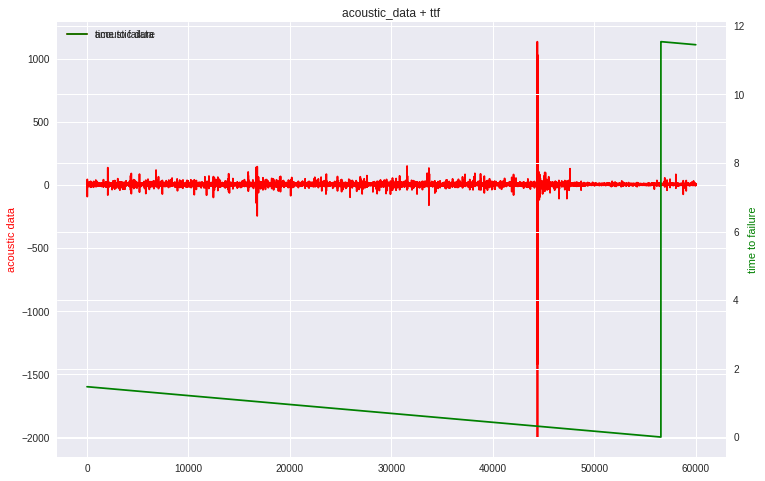

In [22]:
#visualize 1% of sample data, first 100 datapoints
train_ad_sample_df = train['acoustic_data'].values[::100]
train_ttf_sample_df = train['time_to_failure'].values[::100]

#function for plotting  based on both features
def plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title='acoustic_data + ttf'):
  fig, ax1  = plt.subplots(figsize=(12, 8))
  plt.title(title)
  plt.plot(train_ad_sample_df, color='r')
  ax1.set_ylabel('acoustic data', color='r')
  plt.legend(['acoustic data'], loc=(0.01, 0.95))
  ax2 = ax1.twinx()
  plt.plot(train_ttf_sample_df, color='g')
  ax2.set_ylabel('time to failure', color='g')
  plt.legend(['time to failure'], loc=(0.01, 0.95))
  plt.grid(True)
  
plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df)
del train_ad_sample_df
del train_ttf_sample_df

![alt text](https://i.imgur.com/EPAFaPA.png)

**Step 4-Feature Engineering**

In [0]:
#Feature Engineering and significance of these statistical features.
def generate_features(X):
  strain=[]
  strain.append(X.mean())
  strain.append(X.std())
  strain.append(X.min())
  strain.append(X.max())
  strain.append(X.kurtosis())
  strain.append(X.skew())
  strain.append(np.quantile(X,0.01))
  return pd.Series(strain)

In [0]:
train = pd.read_csv('train.csv', iterator=True, chunksize=150_000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

X_train=pd.DataFrame()
y_train=pd.Series()
for df in train:
  ch=generate_features(df['acoustic_data'])
  X_train=X_train.append(ch, ignore_index=True)
  y_train=y_train.append(pd.Series(df['time_to_failure'].values[-1]))

In [5]:
X_train.describe() 

,0,1,2,3,4,5,6
count,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000
mean,4.519475,6.547788,-149.190942,163.522288,68.297997,0.125830,-11.224603
std,0.256049,8.503939,265.087984,272.930331,70.532565,0.477901,14.106852
min,3.596313,2.802720,-5515.000000,23.000000,0.648602,-4.091826,-336.000000
25%,4.349497,4.478637,-154.000000,92.000000,28.090227,-0.040779,-14.000000
50%,4.522147,5.618798,-111.000000,123.000000,45.816625,0.085620,-10.000000
75%,4.693350,6.880904,-79.000000,170.000000,78.664202,0.253930,-6.000000
max,5.391993,153.703569,-15.000000,5444.000000,631.158927,4.219429,-2.000000


**Step 5-Implement CatBoost Model**

In [9]:
#model 1.CatBoost
train_pool = Pool(X_train, y_train)
m = CatBoostRegressor(iterations=10000, loss_function="MAE", boosting_type='Ordered')
m.fit(X_train, y_train, silent=True)
m.best_score_

{'learn': {'MAE': 1.856830702463856}}

**Step 6-Support Vector Machines**

In [11]:
#model 2.SVM
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

parameters = [{'gamma': [0.001, 0.005, 0.01, 0.02, 0.05, 0.1],
               'C': [0.1, 0.2, 0.25, 0.5, 1, 1.5, 2]}]
               #'nu': [0.75, 0.8, 0.85, 0.9, 0.95, 0.97]}]

reg1 = GridSearchCV(SVR(kernel='rbf', tol=0.01), parameters, cv=5, scoring='neg_mean_absolute_error')
reg1.fit(X_train_scaled, y_train.values.flatten())
y_pred1 = reg1.predict(X_train_scaled)

print("Best CV score: {:.4f}".format(reg1.best_score_))
print(reg1.best_params_)

Best CV score: -2.2711
{'C': 2, 'gamma': 0.1}
